# Bayesian models for demographic predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import pystan
import psis
from plot_results import plot_results
import importlib
from plot_pooled_results import plot_results_pooled
from posterior_plot import posterior_predictions

In [2]:
from plot_results import plot_results

In [3]:
data = pd.read_csv("data/data.csv",sep='\t',header=None)

In [4]:
np_data =  data.values
years = np_data[:,0]
males = np_data[:,1:5]
females = np_data[:,5:9]
all_people = np_data[:,1:]

# Description of the data

The dataset contains the number of accepted Finnish citizenships over the years, based on age categories and gender. As will be seen on the plots, the acceptance number has an approximately increasing trend over the years, on each category, so our focus will be on linear regression models.

In [5]:
header = [np.array(['Male','Male','Male','Male','Female','Female','Female','Female']), 
np.array(['0-17','18-34','35-54','55+','0-17','18-34','35-54','55+'])] 
df = pd.DataFrame(all_people, index=data[0].values, columns = header )   
print(df)

      Male                  Female                 
      0-17 18-34 35-54  55+   0-17 18-34 35-54  55+
2010   614   551   475   99    590   833   985  187
2011   613   645   527  118    544   985   904  222
2012  1438  1350  1142  190   1459  1642  1538  328
2013  1509  1483  1070  180   1409  1608  1388  283
2014  1260  1451   906  181   1266  1622  1277  297
2015  1162  1473   977  187   1139  1570  1154  259
2016  1513  1598  1156  194   1431  1751  1422  310
2017  1855  2074  1649  266   1689  2339  1971  376


# Plot data with different colours for each category

In [6]:
from pylab import rcParams
import matplotlib.patches as mpatches
years = data[0].values
colors = ['red','blue','green','orange','red','blue','green','orange']
marks = ['s','s','s','s','^','^','^','^']
legend_labels = ['Male 0-17','Male 18-34','Male 35-54','Male 55+',
                'Female 0-17','Female 18-34','Female 35-54','Female 55+']
rcParams['figure.figsize'] = 14, 8
patches = []
for i in range(8):
    patches.append(mpatches.Patch(color=colors[i],label=legend_labels[i]))

The following scatter plot shows each data point with different colours for each category, and a traingle/x for female/male.

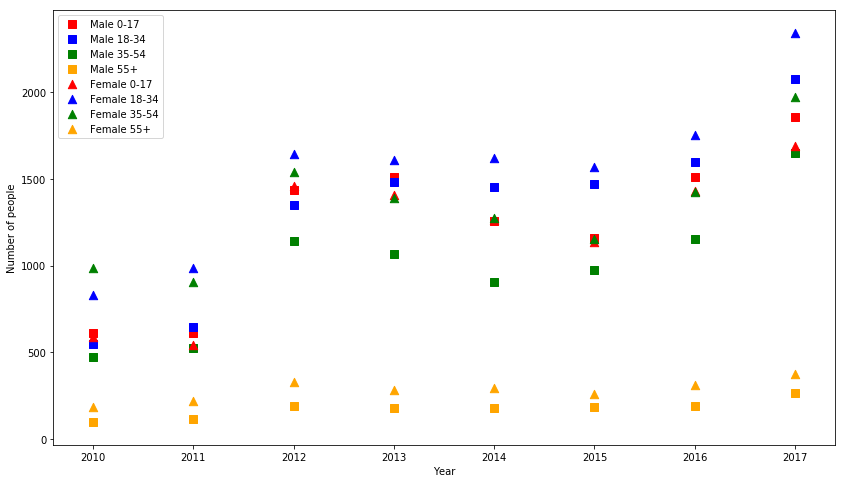

In [7]:
#plt.legend(handles=patches, loc=0, borderaxespad=0)
plt.xlabel("Year")
plt.ylabel("Number of people")
for ind, gender, category in (zip(range(0,8),header[0],header[1])):
    plt.scatter(years,df[:][gender][category].values,c=colors[ind],
                marker=marks[ind],s=70,label=legend_labels[ind])
plt.legend()
plt.show()

Plotting the mean accepted citizens over the years.

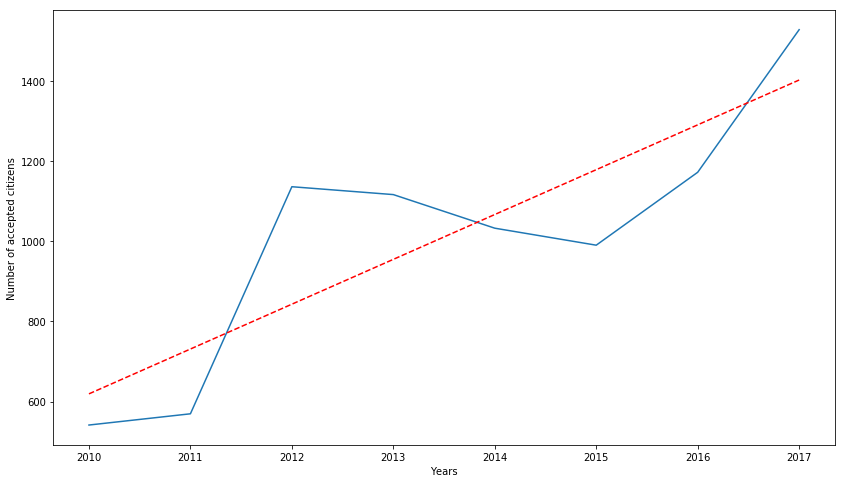

In [8]:
means = np.sum(all_people,axis=1)
means = means/8
pylab.plot(range(2010,2018),means)
z = np.polyfit(range(2010,2018), means, 1)
p = np.poly1d(z)
plt.xlabel("Years")
plt.ylabel("Number of accepted citizens")
pylab.plot(range(2010,2018),p(range(2010,2018)),"r--")

In the above graph, there is a clear approximately increasing trend, and that will be used as our main modeling-focus: models with an increasing mean along the years. Concretely, linear regressions for each of those age categories presented.

## Separate model with flat prior

The first model we tried out is a separate model with linear regressions for each catgory of age for each gender. First, no prior was given (flat prior).

The model will be:
$y_i \sim N(\mu_i, \sigma_{grp-i})$

With $\sigma_{grp-i}$ taken separately for each category and each gender and a $\mu_i$ taken at each data point from it's respective group's regression line - $\mu_i = \alpha_{grp-i} \cdot years + \beta_{grp-i}$.

The regression lines are infered by taking the number of accepted citizens as a function of years. The reason is somewhat intuitively obvious, as there seems to be some clear increasing trend for each category, as shown in the plots.

In [9]:
population_model_seaprate ="""
data{
    int<lower=0> N;         // number of data points
    int<lower=0> G;         // number of groups
    vector[N] years;        // years 2010...2017
    vector<lower=0>[N] y;   // the actual number of accepted citizens
    int grps_ind[N];        // group indicator vector (1,2,...,8,1,2...,8...)
    real xpred;             // year 2018
}
parameters{
    vector[G] alpha;           // regression paramters for our 
    vector[G] beta;            // data points means (separate for each age category)
    vector<lower=0>[G] sigma;  // common sigma for each group
}
transformed parameters{
    vector[N] mu;          
    for (i in 1:N)                 
        mu[i] =  alpha[grps_ind[i]]*years[i] + beta[grps_ind[i]]; 
                                            // transformed mu as a 
                                            // linear function of years
}
model{
    for (i in 1:N)
        y[i] ~ normal(mu[i],sigma[grps_ind[i]]);                  
                        // normal distribution around 
                        // each point
}
generated quantities {
    vector[G] y_pred_18;          //predictions for each age category
    vector[N] log_lik;
    real x_pred;
    for (i in 1:G)
        y_pred_18[i] = normal_rng(alpha[grps_ind[i]]*xpred + 
                        beta[grps_ind[i]],sigma[grps_ind[i]]);
    
    for (i in 1:N)
        log_lik[i] = normal_lpdf(y[i] | mu[i], sigma[grps_ind[i]]);    
                                            //log likelyhood values
}

"""
separate = pystan.StanModel(model_code=population_model_seaprate)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ebec5450bc9a61212360b4ef1ebb9714 NOW.
/home/alex/anaconda3/envs/bda_env/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpbhc_c8u8/stanfit4anon_model_ebec5450bc9a61212360b4ef1ebb9714_8143131884180699410.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [10]:
years = np.array(list(range(2010,2018,1))).reshape((8,1))
years = np.tile(years,8).flatten()

separate_data ={
    'N': all_people.size,
    'G':8,
    'years':years,
    'y': all_people.flatten(),
    'grps_ind': list(range(1,9,1))*8,
    'xpred': 2018,
}

In [11]:
fit_seaprate_no_prior = separate.sampling(data=separate_data,
            iter=1000,chains=4,control={"max_treedepth":20})

__Convergence analysis__

In [12]:
summary = fit_seaprate_no_prior.summary(pars=['alpha','beta','sigma'])

df = pd.DataFrame(
    summary['summary'],
    index = summary['summary_rownames'],
    columns = summary['summary_colnames'])

In [13]:
df.loc['beta[1]':'beta[9]','n_eff':'Rhat'].T

,beta[1],beta[2],beta[3],beta[4],beta[5],beta[6],beta[7],beta[8]
n_eff,734.275339,681.194171,1168.296961,714.672116,757.918865,751.080396,871.690488,777.948031
Rhat,1.003142,1.001217,1.001884,0.999747,1.002840,1.001747,0.999858,1.002494


In [14]:
df.loc['alpha[1]':'alpha[9]','n_eff':'Rhat'].T

,alpha[1],alpha[2],alpha[3],alpha[4],alpha[5],alpha[6],alpha[7],alpha[8]
n_eff,734.188842,681.156212,1168.019819,714.159016,757.936822,751.187152,871.753992,777.940796
Rhat,1.003142,1.001220,1.001884,0.999746,1.002839,1.001750,0.999860,1.002497


__K values and log psis measurements__

Our k values turn out to be below 0.7, so our psis value will be a reliable assesment for the model.

(array([ 4.,  2.,  4.,  6., 11., 13.,  8.,  5.,  9.,  2.]),
 array([-0.09419013, -0.00551527,  0.0831596 ,  0.17183446,  0.26050933,
         0.34918419,  0.43785905,  0.52653392,  0.61520878,  0.70388365,
         0.79255851]),
 <a list of 10 Patch objects>)

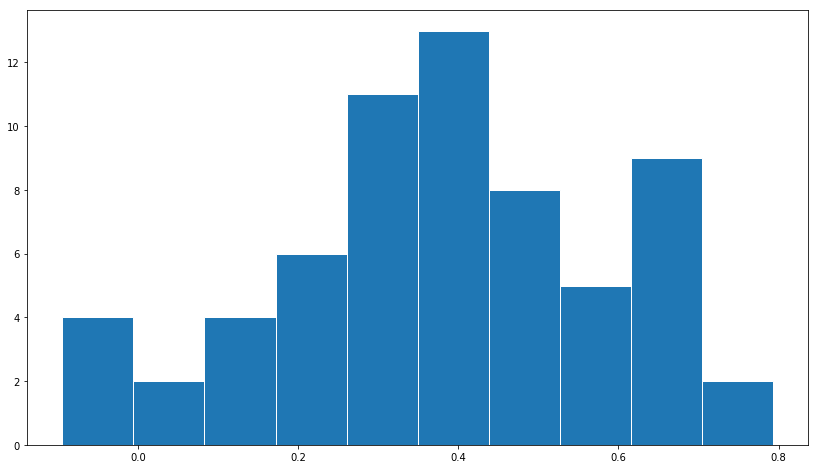

In [15]:
results = psis.psisloo(fit_seaprate_no_prior.extract()['log_lik'])
log_lik = fit_seaprate_no_prior.extract()['log_lik']
means = np.mean(np.exp(log_lik),axis=0)
sums = np.sum(np.log(means))
p_eff = sums  - results[0]
plt.hist(psis.psisloo(fit_seaprate_no_prior.extract()['log_lik'])[2],ec='white')

In [16]:
print(results[0])

-431.0623230677427


__P_eff value__

In [17]:
print(p_eff)

17.85413169561059


In [18]:
summary = fit_seaprate_no_prior.summary(pars=['mu'])

In [19]:
df = pd.DataFrame(
    summary['summary'],
    index = summary['summary_rownames'],
    columns = summary['summary_colnames'])

In [20]:
all_mus2_5 = []
all_mus97_5 = []
for i in range(1,65):
    current_mu = df.loc['mu[' + str(i)+ "]"]
    all_mus2_5.append(current_mu[3])
    all_mus97_5.append(current_mu[7])
    

In [21]:
all_mus2_5 = np.array(all_mus2_5)
all_mus97_5 = np.array(all_mus97_5)
all_mus2_5 = np.reshape(all_mus2_5,(8,8))
all_mus97_5 = np.reshape(all_mus97_5,(8,8))

## Plot results

A plot containing the regression lines for each category (each $\alpha$ and $\beta$). The green and blue dotted lines represent the 95% central interval for our $\mu$ values, sampled from a normal distribution around that line. The x mark at the end represents the predicted value for 2018.

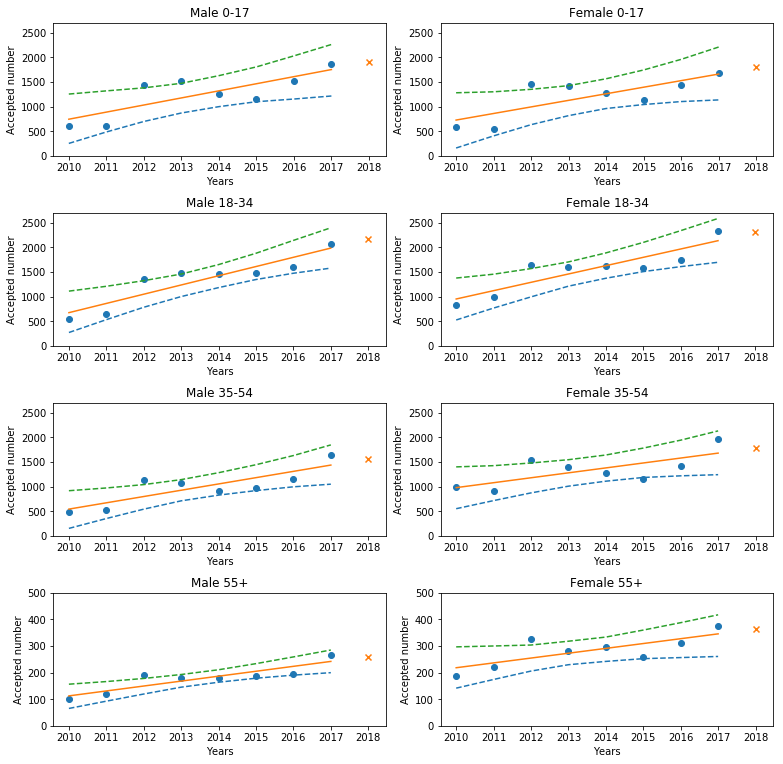

In [22]:
plot_results(fit_seaprate_no_prior,all_mus2_5,all_mus97_5,all_people)

In [23]:
new_predictions = fit_seaprate_no_prior.extract()['y_pred_18']
new_predictions = new_predictions.T

__Posterior predictive checking__

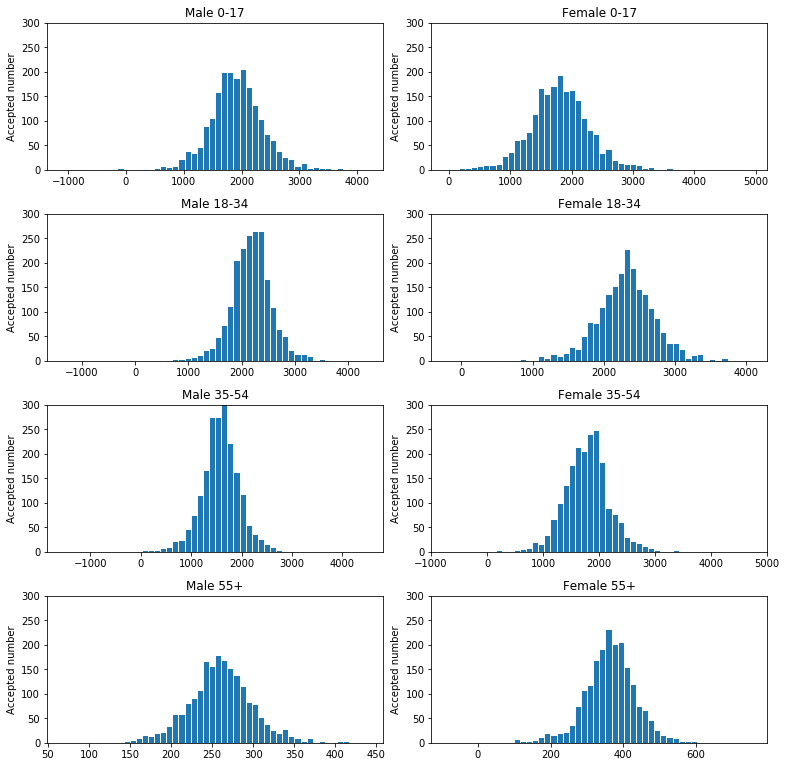

In [24]:
posterior_predictions(new_predictions)

## Defining a good prior for our models

Next, we will try to figure out a good prior for the model. Concretely, we will define a prior such that the slope parameter $\alpha$ will fit properly the data for the previous years.

The reason for taking such a prior is to "help" the model infer better, using what seems to be reasonable limits for the increase and decrease of the number of accepted finnish citizenships from one year to another.

This secondary data (from which we are deciding on our prior) contains the number of granted citizenships over earlyer years (1990-2017), but it does not contain the data based on age categories. Therefore, we will use it as a loosely informative prior for our slope, considering these differences divided by 8 to be a good rough estimate for acceptance number of citizens in each category

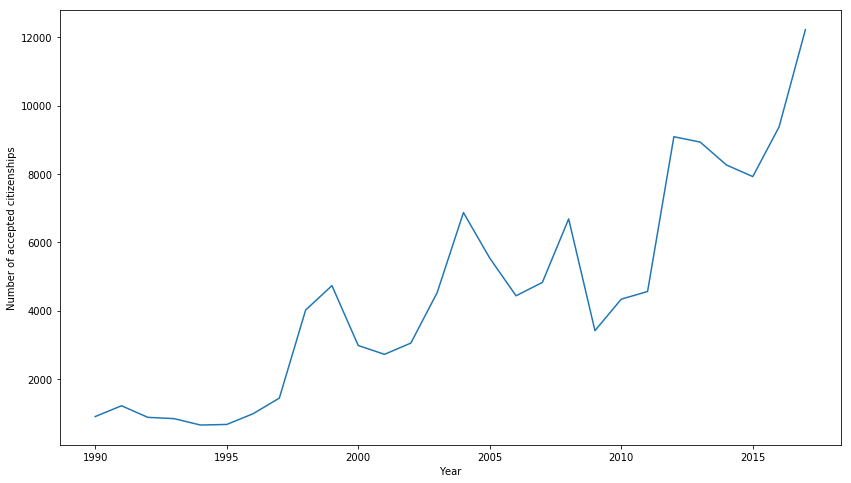

In [25]:
total_citizens_1990 = pd.read_csv('data/total_accepted.csv',header=None)
plt.ylabel("Number of accepted citizenships")
plt.xlabel("Year")
plt.plot(total_citizens_1990.values[:,0],total_citizens_1990.values[:,1])

In [26]:
people_2009 = total_citizens_1990
people_2009 = people_2009.values[:,1]
diff_2009 = people_2009[1:21] - people_2009[:20]

avg_diff_2009 = diff_2009/8

print(np.mean(avg_diff_2009))
print(np.std(avg_diff_2009))

21.46875
168.07122687922373


These values represent an "average slope" over each two consecutive years, or to be exact, diff$_{2009}[i]=\frac{No_{citizens}[year_i]-No_{citizens}[year_{i-1}]}{year_i-year_{i-1}}$, with the denominator being obviously 1.

The only change in the model is:

$y_i \propto p(y_i |\mu_i, \sigma_{grp-i})p(\mu | \tau)$

With $\tau ~ N(\mu_{prior},\sigma_{prior})$, having the prior normal parameters taken from the calculations above.

# Separate model with normal prior for year parameter

In [27]:
population_model_seaprate ="""
data{
    real prior_sigma;
    real prior_mu;
    int<lower=0> N;         // number of data points
    int<lower=0> G;         // number of groups
    vector[N] years;        // years 2010...2017
    vector<lower=0>[N] y;   // the actual number of accepted citizens
    int grps_ind[N];        // group indicator vector (1,2,...,8,1,2...,8...)
    real xpred;             // year 2018
}
parameters{
    vector[G] alpha;           // regression paramters for our 
    vector[G] beta;            // data points means (separate for each age category)
    vector<lower=0>[G] sigma;  // common sigma for each group
}
transformed parameters{
    vector[N] mu;
    for (i in 1:N)                 
        mu[i] =  alpha[grps_ind[i]]*years[i] + beta[grps_ind[i]]; 
                                        // transformed mu as a 
                                        // linear function of years
}
model{
    alpha ~ normal(prior_mu,prior_sigma);
            // prior for the alpha parameter
    for (i in 1:N)
        y[i] ~ normal(mu[i],sigma[grps_ind[i]]);                  
                    // normal distribution around 
                    // each point
}
generated quantities {
    vector[G] y_pred_18;
    vector[N] log_lik;
    real x_pred;
    for (i in 1:G)
        y_pred_18[i] = normal_rng(alpha[grps_ind[i]]*xpred + 
                        beta[grps_ind[i]],sigma[grps_ind[i]]);
    
    for (i in 1:N)
        log_lik[i] = normal_lpdf(y[i] | mu[i], sigma[grps_ind[i]]);

}

"""
separate_with_prior = pystan.StanModel(model_code=population_model_seaprate)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4c9a74783aab0891ae1608cc2393825e NOW.
/home/alex/anaconda3/envs/bda_env/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmprkm1iee3/stanfit4anon_model_4c9a74783aab0891ae1608cc2393825e_7373090606985396929.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [28]:
years = np.array(list(range(2010,2018,1))).reshape((8,1))
years = np.tile(years,8).flatten()

separate_data ={
    'N': all_people.size,
    'G':8,
    'years':years,
    'y': all_people.flatten(),
    'grps_ind': list(range(1,9,1))*8,
    'xpred': 2018,
    'prior_sigma': 168.071,
    'prior_mu': 21.46875
}

In [29]:
fit_separate_prior = separate_with_prior.sampling(data=separate_data,iter=1000,chains=4,control={"max_treedepth":20})

__Convergence analysis__

In [30]:
summary = fit_separate_prior.summary(pars=['alpha','beta','sigma'])

df = pd.DataFrame(
    summary['summary'],
    index = summary['summary_rownames'],
    columns = summary['summary_colnames'])
df.loc['beta[1]':'beta[9]','n_eff':'Rhat'].T

,beta[1],beta[2],beta[3],beta[4],beta[5],beta[6],beta[7],beta[8]
n_eff,854.680670,888.452649,767.429930,589.274707,953.754954,651.659739,589.090208,587.387977
Rhat,1.001303,1.001358,1.004714,1.009203,1.001969,1.006319,1.004528,1.008823


In [31]:
df.loc['alpha[1]':'alpha[9]','n_eff':'Rhat'].T

,alpha[1],alpha[2],alpha[3],alpha[4],alpha[5],alpha[6],alpha[7],alpha[8]
n_eff,854.553445,888.345538,767.061216,589.306931,953.785297,651.826978,589.046846,587.232451
Rhat,1.001302,1.001359,1.004712,1.009203,1.001968,1.006311,1.004528,1.008827


__K values and log psis measurements__

(array([ 4.,  8., 11., 11.,  4., 11.,  8.,  4.,  0.,  3.]),
 array([0.0613609 , 0.13834335, 0.21532579, 0.29230824, 0.36929068,
        0.44627313, 0.52325557, 0.60023802, 0.67722046, 0.75420291,
        0.83118535]),
 <a list of 10 Patch objects>)

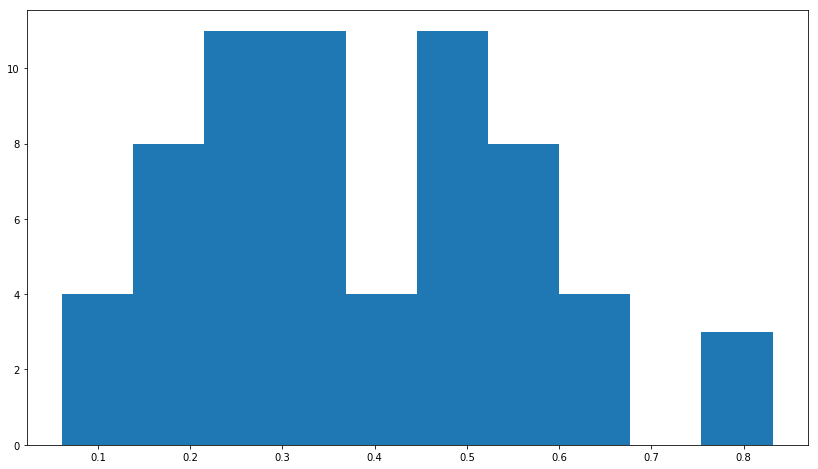

In [32]:
results = psis.psisloo(fit_separate_prior.extract()['log_lik'])
log_lik = fit_separate_prior.extract()['log_lik']
means = np.mean(np.exp(log_lik),axis=0)
sums = np.sum(np.log(means))
p_eff = sums  - results[0]
plt.hist(psis.psisloo(fit_separate_prior.extract()['log_lik'])[2])

In [33]:
print(results[0])

-430.5850417297303


__P_eff value__

In [34]:
print(p_eff)

17.625156840063596


In [35]:
summary = fit_separate_prior.summary(pars=['mu'])

In [36]:
df = pd.DataFrame(
    summary['summary'],
    index = summary['summary_rownames'],
    columns = summary['summary_colnames'])

In [37]:
all_mus2_5 = []
all_mus97_5 = []
for i in range(1,65):
    current_mu = df.loc['mu[' + str(i)+ "]"]
    all_mus2_5.append(current_mu[3])
    all_mus97_5.append(current_mu[7])
    

In [38]:
all_mus2_5 = np.array(all_mus2_5)
all_mus97_5 = np.array(all_mus97_5)
all_mus2_5 = np.reshape(all_mus2_5,(8,8))
all_mus97_5 = np.reshape(all_mus97_5,(8,8))

## Plot results

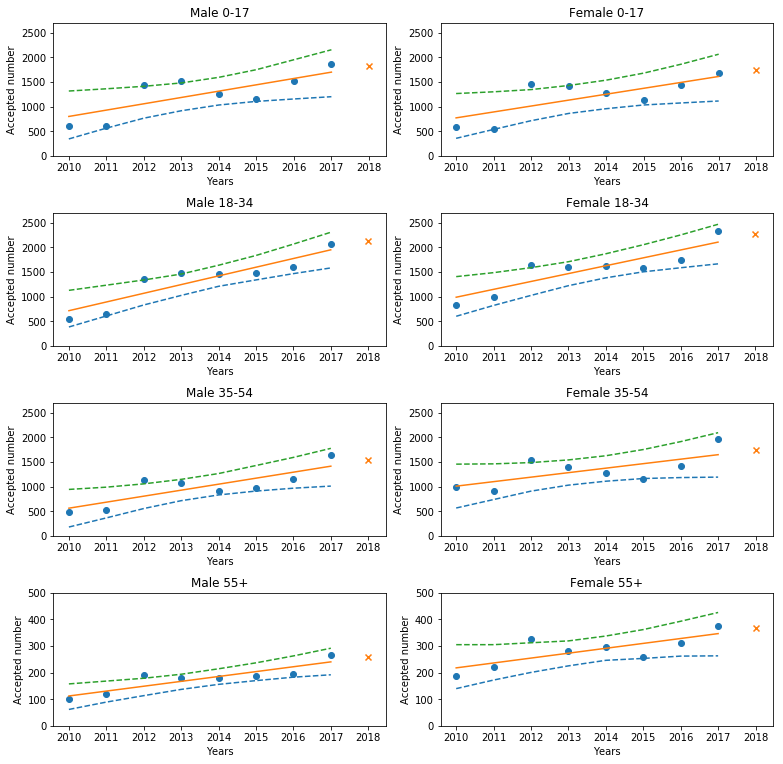

In [39]:
plot_results(fit_separate_prior,all_mus2_5,all_mus97_5,all_people)

The same plots as before, now with parameters infered with weekly informative prior.

__Posterior predictive checking__

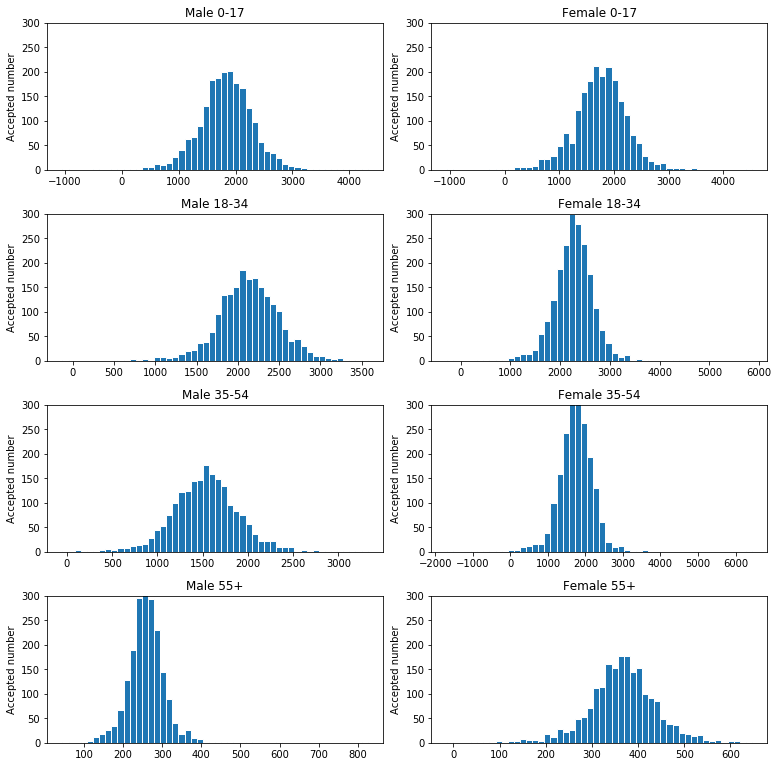

In [40]:
new_predictions = fit_separate_prior.extract()['y_pred_18']
new_predictions = new_predictions.T

posterior_predictions(new_predictions)

# Hierarchical model for the slope $\alpha$

In [41]:
population_model_hierarchical ="""
data{
    int<lower=0> N;         // number of data points
    int<lower=0> G;         // number of groups
    vector[N] years;        // years 2010...2017
    vector<lower=0>[N] y;   // the actual number of accepted citizens
    int grps_ind[N];        // group indicator vector (1,2,...,8,1,2...,8...)
    real xpred;             // year 2018
}
parameters{
    vector[G] alpha;           // regression paramters for our 
    vector[G] beta;            // data points means (separate for each age category)
    vector<lower=0>[G] sigma;  // common sigma for each group
    real mu0;
    real<lower=0> sigma0;
}
transformed parameters{
    vector[N] mu;
    for (i in 1:N)                 
        mu[i] =  alpha[grps_ind[i]]*years[i] + beta[grps_ind[i]]; 
                                            // transformed mu as a 
                                            // linear function of years
}
model{
    alpha ~ normal(mu0,sigma0);                                   
                                // hierarchy on the slopes
    for (i in 1:N)
        y[i] ~ normal(mu[i],sigma[grps_ind[i]]);                  
                                // normal distribution around 
                                // each point;
}
generated quantities {
    vector[G] y_pred_18;
    vector[N] log_lik;
    real x_pred;
    for (i in 1:G)
        y_pred_18[i] = normal_rng(alpha[grps_ind[i]]*xpred + 
                        beta[grps_ind[i]],sigma[grps_ind[i]]);
    
    for (i in 1:N)
        log_lik[i] = normal_lpdf(y[i] | mu[i], sigma[grps_ind[i]]);

}

"""
hierarchical_slope = \
    pystan.StanModel(model_code=population_model_hierarchical)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_654a7070a34f5b310c2843bdc2ebfc56 NOW.
/home/alex/anaconda3/envs/bda_env/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp6td_1qem/stanfit4anon_model_654a7070a34f5b310c2843bdc2ebfc56_6643867222918990145.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [42]:
years = np.array(list(range(2010,2018,1))).reshape((8,1))
years = np.tile(years,8).flatten()

hierarchical_data ={
    'N': all_people.size,
    'G':8,
    'years':years,
    'y': all_people.flatten(),
    'grps_ind': list(range(1,9,1))*8,
    'xpred': 2018
}

In [43]:
fit_hierarchical_slope = hierarchical_slope.sampling(data=hierarchical_data,
                            iter=1000,chains=4,control={"max_treedepth":20})

__Convergence analysis__

In [44]:
summary = fit_hierarchical_slope.summary(pars=['alpha','beta','sigma'])

df = pd.DataFrame(
    summary['summary'],
    index = summary['summary_rownames'],
    columns = summary['summary_colnames'])



df.loc['beta[1]':'beta[9]','n_eff':'Rhat'].T

,beta[1],beta[2],beta[3],beta[4],beta[5],beta[6],beta[7],beta[8]
n_eff,719.401576,988.928824,835.157222,1009.028555,844.161009,905.700833,1090.848784,560.472713
Rhat,1.001993,1.002045,1.003001,1.004160,1.002566,1.001881,1.002709,1.007586


In [45]:
df.loc['alpha[1]':'alpha[9]','n_eff':'Rhat'].T

,alpha[1],alpha[2],alpha[3],alpha[4],alpha[5],alpha[6],alpha[7],alpha[8]
n_eff,719.496771,988.907347,835.227655,1008.823675,844.071422,905.146115,1091.549263,560.775264
Rhat,1.001988,1.002047,1.003004,1.004158,1.002564,1.001880,1.002710,1.007587


(array([ 2.,  4., 11.,  8.,  8., 15.,  9.,  3.,  3.,  1.]),
 array([-0.01465128,  0.07183296,  0.15831719,  0.24480143,  0.33128567,
         0.41776991,  0.50425415,  0.59073838,  0.67722262,  0.76370686,
         0.8501911 ]),
 <a list of 10 Patch objects>)

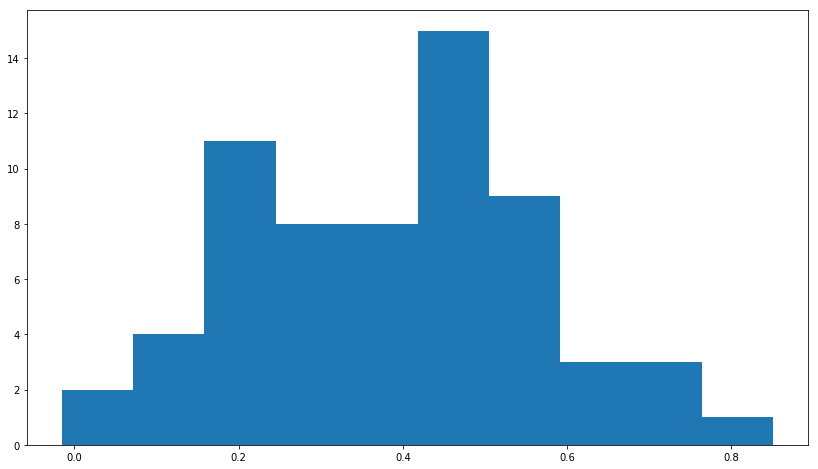

In [46]:
results = psis.psisloo(fit_hierarchical_slope.extract()['log_lik'])
log_lik = fit_hierarchical_slope.extract()['log_lik']
means = np.mean(np.exp(log_lik),axis=0)
sums = np.sum(np.log(means))
p_eff = sums  - results[0]
plt.hist(psis.psisloo(fit_hierarchical_slope.extract()['log_lik'])[2])

In [47]:
print(results[0])

-429.4358736763847


__P_eff value__

In [48]:
print(p_eff)

16.918769153092967


In [49]:
summary = fit_hierarchical_slope.summary(pars=['mu'])


df = pd.DataFrame(
    summary['summary'],
    index = summary['summary_rownames'],
    columns = summary['summary_colnames'])

all_mus2_5 = []
all_mus97_5 = []
for i in range(1,65):
    current_mu = df.loc['mu[' + str(i)+ "]"]
    all_mus2_5.append(current_mu[3])
    all_mus97_5.append(current_mu[7])
    

all_mus2_5 = np.array(all_mus2_5)
all_mus97_5 = np.array(all_mus97_5)
all_mus2_5 = np.reshape(all_mus2_5,(8,8))
all_mus97_5 = np.reshape(all_mus97_5,(8,8))

## Plot results

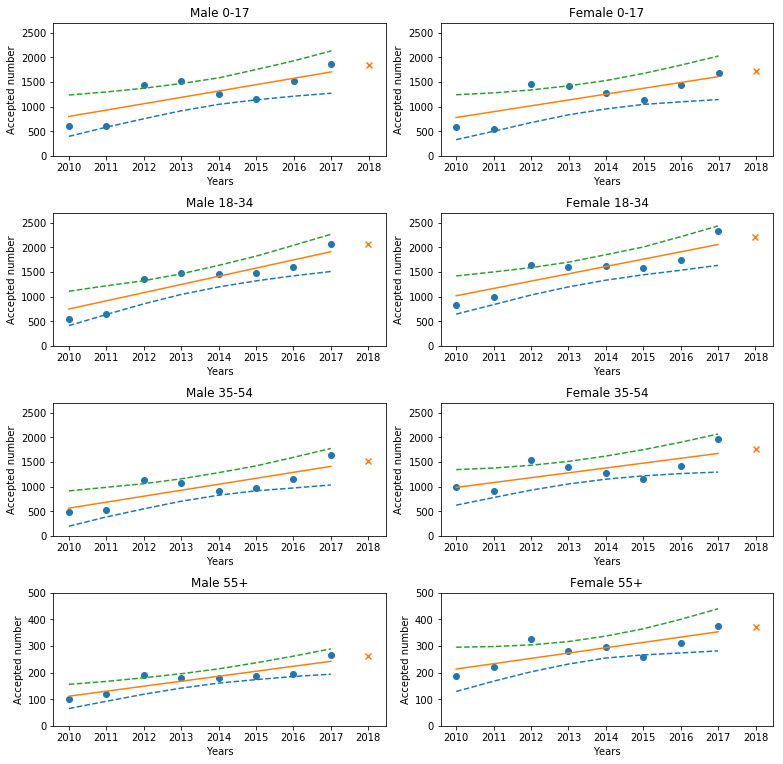

In [50]:
plot_results(fit_hierarchical_slope,all_mus2_5,all_mus97_5,all_people)

__Posterior predictive checking__

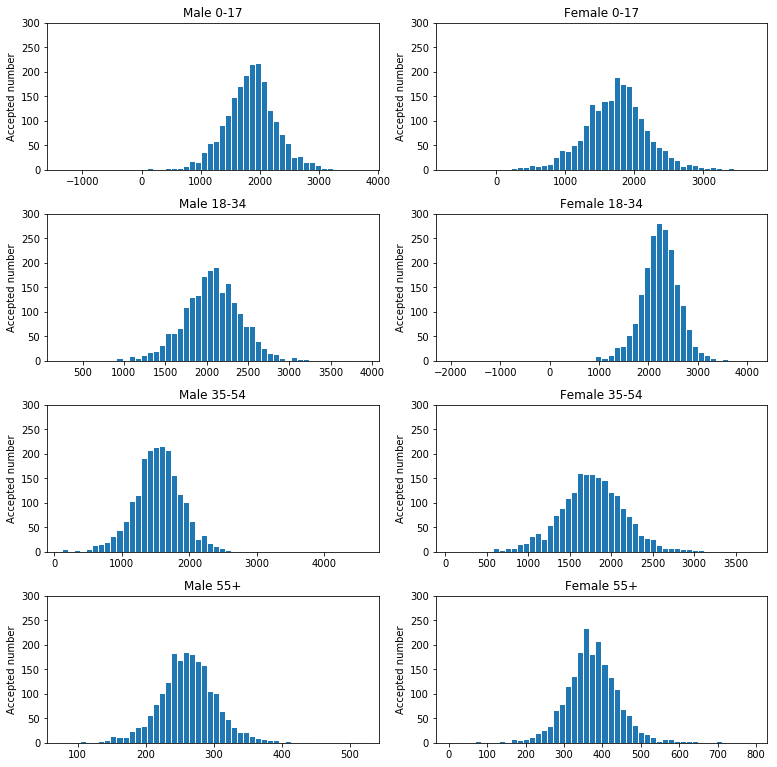

In [51]:
new_predictions = fit_hierarchical_slope.extract()['y_pred_18']
new_predictions = new_predictions.T

posterior_predictions(new_predictions)

# Hierarchical model for $\beta$

In [52]:
population_model_hierarchical ="""
data{
    int<lower=0> N;         // number of data points
    int<lower=0> G;         // number of groups
    vector[N] years;        // years 2010...2017
    vector<lower=0>[N] y;   // the actual number of accepted citizens
    int grps_ind[N];        // group indicator vector (1,2,...,8,1,2...,8...)
    real xpred;             // year 2018
}
parameters{
    vector[G] alpha;           // regression paramters for our 
    vector[G] beta;            // data points means (separate for each age category)
    vector<lower=0>[G] sigma;  // common sigma for each group
    real mu0_beta;
    real<lower=0>sigma0_beta;
}
transformed parameters{
    vector[N] mu;
    for (i in 1:N)                 
        mu[i] =  alpha[grps_ind[i]]*years[i] + beta[grps_ind[i]]; 
                                            // transformed mu as a 
                                            // linear function of years
}
model{
    beta ~ normal(mu0_beta,sigma0_beta); 
                    // hierarchy on alpha
    for (i in 1:N)
        y[i] ~ normal(mu[i],sigma[grps_ind[i]]);
                        // normal distribution around 
                        // each point;
}
generated quantities {
    vector[G] y_pred_18;
    vector[N] log_lik;
    real x_pred;
    for (i in 1:G)
        y_pred_18[i] = normal_rng(alpha[grps_ind[i]]*xpred +
                        beta[grps_ind[i]],sigma[grps_ind[i]]);
    
    for (i in 1:N)
        log_lik[i] = normal_lpdf(y[i] | mu[i], sigma[grps_ind[i]]);

}

"""
hierarchical_beta = \
    pystan.StanModel(model_code=population_model_hierarchical)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_859fde05b9d40f754ed8fa3c80d70c3a NOW.
/home/alex/anaconda3/envs/bda_env/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpzwegamgn/stanfit4anon_model_859fde05b9d40f754ed8fa3c80d70c3a_4897056375597781883.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [53]:
years = np.array(list(range(2010,2018,1))).reshape((8,1))
years = np.tile(years,8).flatten()

hierarchical_data ={
    'N': all_people.size,
    'G':8,
    'years':years,
    'y': all_people.flatten(),
    'grps_ind': list(range(1,9,1))*8,
    'xpred': 2018
}

In [54]:
fit_hierarchical_beta = hierarchical_beta.sampling(data=hierarchical_data,
        iter=1000,chains=4,control={"max_treedepth":20,"adapt_delta":0.95})

__Convergence analysis__

In [55]:
summary = fit_hierarchical_beta.summary(pars=['alpha','beta','sigma'])

df = pd.DataFrame(
    summary['summary'],
    index = summary['summary_rownames'],
    columns = summary['summary_colnames'])

df.loc['beta[1]':'beta[9]','n_eff':'Rhat'].T

,beta[1],beta[2],beta[3],beta[4],beta[5],beta[6],beta[7],beta[8]
n_eff,1455.529815,906.771777,992.101217,766.872885,1343.470643,1233.555436,1256.941022,880.934102
Rhat,1.001014,0.999988,1.001424,1.002008,1.001581,1.002477,0.998853,1.003198


In [56]:
df.loc['alpha[1]':'alpha[9]','n_eff':'Rhat'].T

,alpha[1],alpha[2],alpha[3],alpha[4],alpha[5],alpha[6],alpha[7],alpha[8]
n_eff,1455.763507,906.813353,992.159739,766.707609,1343.460045,1233.480069,1256.033459,880.900248
Rhat,1.001014,0.999987,1.001424,1.002007,1.001582,1.002478,0.998855,1.003202


(array([12.,  6.,  4., 13., 14., 10.,  3.,  1.,  0.,  1.]),
 array([0.12573097, 0.20463914, 0.28354731, 0.36245548, 0.44136365,
        0.52027182, 0.59917999, 0.67808816, 0.75699633, 0.83590449,
        0.91481266]),
 <a list of 10 Patch objects>)

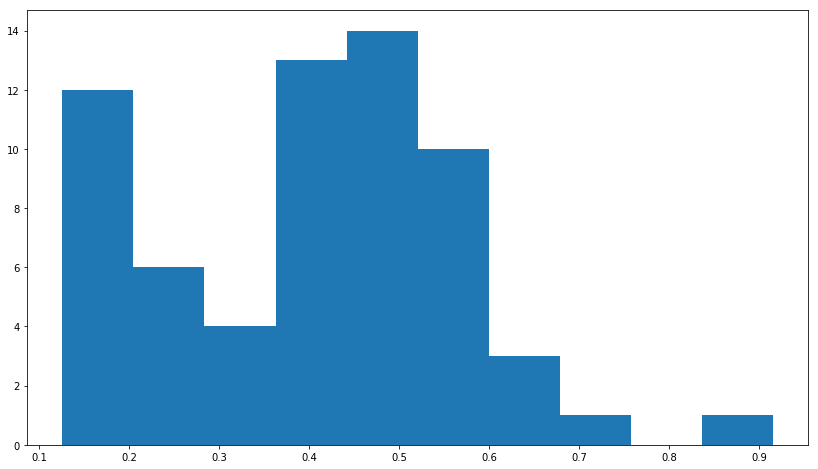

In [57]:
results = psis.psisloo(fit_hierarchical_beta.extract()['log_lik'])
log_lik = fit_hierarchical_beta.extract()['log_lik']
means = np.mean(np.exp(log_lik),axis=0)
sums = np.sum(np.log(means))
p_eff = sums  - results[0]
plt.hist(psis.psisloo(fit_hierarchical_beta.extract()['log_lik'])[2])

In [58]:
print(results[0])

-429.43495829460403


__P_eff value__

In [59]:
print(p_eff)

16.856519732153743


In [60]:
summary = fit_hierarchical_beta.summary(pars=['mu'])


df = pd.DataFrame(
    summary['summary'],
    index = summary['summary_rownames'],
    columns = summary['summary_colnames'])

all_mus2_5 = []
all_mus97_5 = []
for i in range(1,65):
    current_mu = df.loc['mu[' + str(i)+ "]"]
    all_mus2_5.append(current_mu[3])
    all_mus97_5.append(current_mu[7])
    

all_mus2_5 = np.array(all_mus2_5)
all_mus97_5 = np.array(all_mus97_5)
all_mus2_5 = np.reshape(all_mus2_5,(8,8))
all_mus97_5 = np.reshape(all_mus97_5,(8,8))

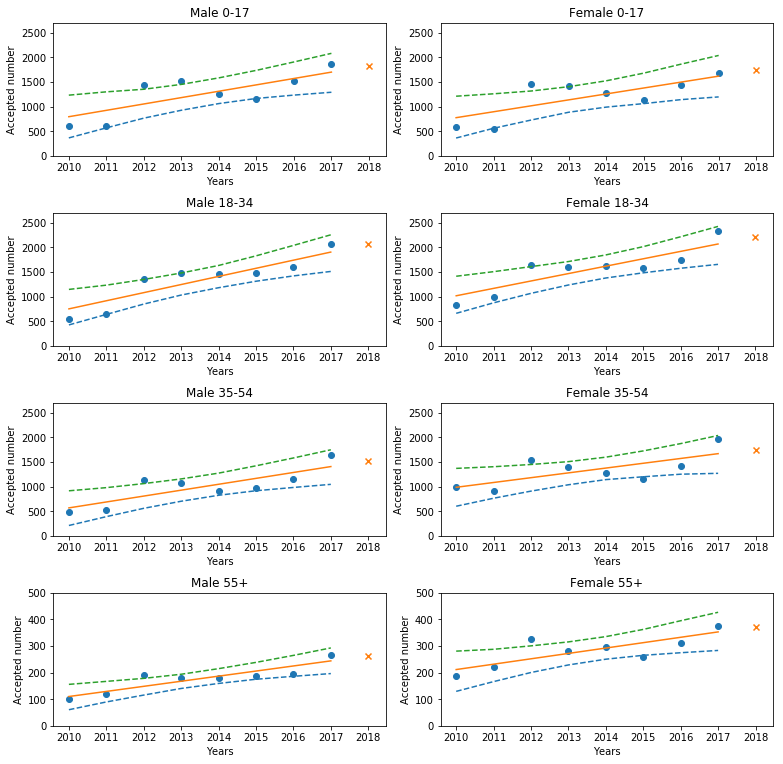

In [61]:
plot_results(fit_hierarchical_beta,all_mus2_5,all_mus97_5,all_people)

__Posterior predictive checking__

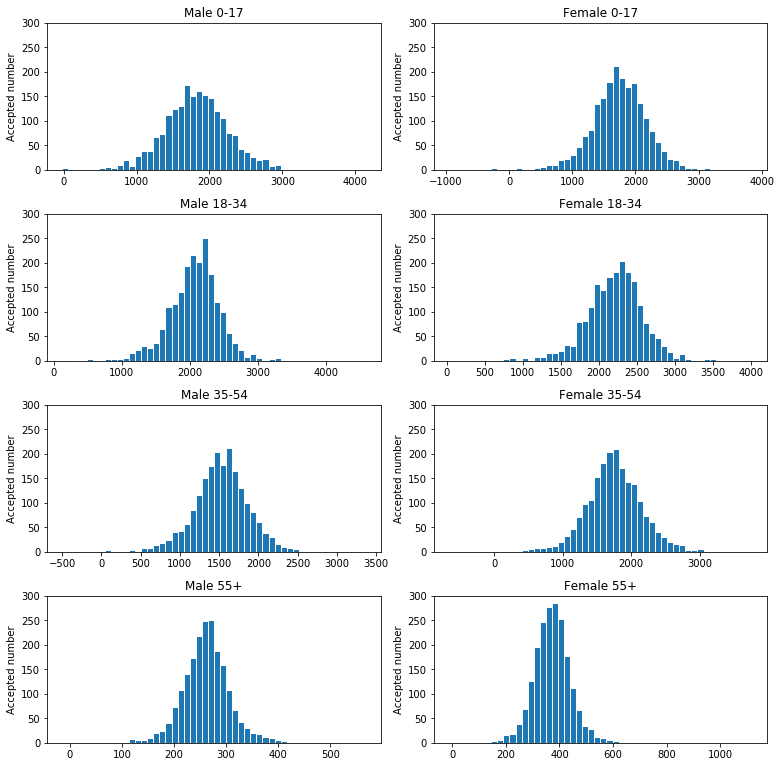

In [62]:
new_predictions = fit_hierarchical_beta.extract()['y_pred_18']
new_predictions = new_predictions.T

posterior_predictions(new_predictions)

# Hierarchical model for $\alpha$ and $\sigma$ and flat prior

In [63]:
population_model_hierarchical ="""
data{
    int<lower=0> N;         // number of data points
    int<lower=0> G;         // number of groups
    vector[N] years;        // years 2010...2017
    vector<lower=0>[N] y;   // the actual number of accepted citizens
    int grps_ind[N];        // group indicator vector (1,2,...,8,1,2...,8...)
    real xpred;             // year 2018
}
parameters{
    vector[G] alpha;           // regression paramters for our 
    vector[G] beta;            // data points means (separate for each age category)
    vector<lower=0>[G] sigma;  // common sigma for each group
    real mu0_alpha;
    real<lower=0>sigma0_alpha;
    real p1;
    real p2;
}
transformed parameters{
    vector[N] mu;
    for (i in 1:N)                 
        mu[i] =  alpha[grps_ind[i]]*years[i] + beta[grps_ind[i]]; 
                                            // transformed mu as a 
                                            // linear function of years
}
model{
    sigma ~ cauchy(p1, p2); 
                        // hierarchy on sigma
    alpha ~ normal(mu0_alpha,sigma0_alpha);
                        // hierarchy on alpha
    for (i in 1:N)
        y[i] ~ normal(mu[i],sigma[grps_ind[i]]);
                    // normal distribution around 
                    // each point;
  
}
generated quantities {
    vector[G] y_pred_18;
    vector[N] log_lik;
    real x_pred;
    for (i in 1:G)
        y_pred_18[i] = normal_rng(alpha[grps_ind[i]]*xpred +
                        beta[grps_ind[i]],sigma[grps_ind[i]]);
    
    for (i in 1:N)
        log_lik[i] = normal_lpdf(y[i] | mu[i], sigma[grps_ind[i]]);

}

"""
hierarchical_both_parameters = \
    pystan.StanModel(model_code=population_model_hierarchical)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_73a79f0f691e7fed00bdd710abaab9ba NOW.
/home/alex/anaconda3/envs/bda_env/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp87zkni71/stanfit4anon_model_73a79f0f691e7fed00bdd710abaab9ba_1655924069830475426.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [64]:
years = np.array(list(range(2010,2018,1))).reshape((8,1))
years = np.tile(years,8).flatten()

hierarchical_data ={
    'N': all_people.size,
    'G':8,
    'years':years,
    'y': all_people.flatten(),
    'grps_ind': list(range(1,9,1))*8,
    'xpred': 2018
}

In [65]:
fit_hier_sgm_alpha = hierarchical_both_parameters.sampling(data=hierarchical_data,
                iter=1000,chains=4,control={"adapt_delta":0.95,"max_treedepth":18})

__Convergence analysis__

In [66]:
summary = fit_hier_sgm_alpha.summary(pars=['alpha','beta','sigma'])

df = pd.DataFrame(
    summary['summary'],
    index = summary['summary_rownames'],
    columns = summary['summary_colnames'])
df.loc['beta[1]':'beta[9]','n_eff':'Rhat'].T

,beta[1],beta[2],beta[3],beta[4],beta[5],beta[6],beta[7],beta[8]
n_eff,1528.904263,1036.453925,1237.151423,448.133787,1112.359545,1032.293304,1330.680987,945.796667
Rhat,0.999317,1.003238,1.000715,1.014964,1.001097,1.003617,1.004387,1.002897


In [67]:
df.loc['alpha[1]':'alpha[9]','n_eff':'Rhat'].T

,alpha[1],alpha[2],alpha[3],alpha[4],alpha[5],alpha[6],alpha[7],alpha[8]
n_eff,1529.603146,1036.589186,1237.199527,447.986471,1112.483167,1032.388794,1330.370950,946.151505
Rhat,0.999320,1.003237,1.000713,1.014969,1.001095,1.003617,1.004383,1.002892


(array([ 6.,  3.,  7., 10., 14.,  8.,  6.,  7.,  2.,  1.]),
 array([-0.09112008,  0.0075029 ,  0.10612589,  0.20474888,  0.30337186,
         0.40199485,  0.50061784,  0.59924083,  0.69786381,  0.7964868 ,
         0.89510979]),
 <a list of 10 Patch objects>)

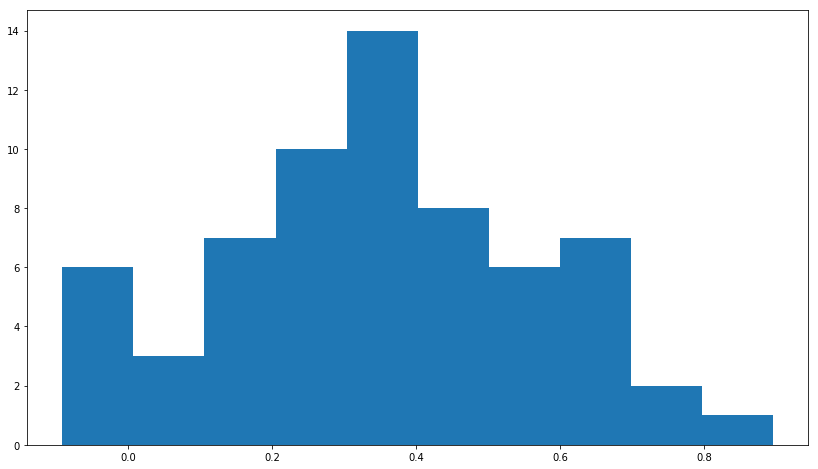

In [68]:
results = psis.psisloo(fit_hier_sgm_alpha.extract()['log_lik'])
log_lik = fit_hier_sgm_alpha.extract()['log_lik']
means = np.mean(np.exp(log_lik),axis=0)
sums = np.sum(np.log(means))
p_eff = sums  - results[0]
plt.hist(psis.psisloo(fit_hier_sgm_alpha.extract()['log_lik'])[2])

In [69]:
print(results[0])

-426.9429453243187


__P_eff value__

In [70]:
print(p_eff)

17.26998796775183


In [71]:
summary = fit_hier_sgm_alpha.summary(pars=['mu'])


df = pd.DataFrame(
    summary['summary'],
    index = summary['summary_rownames'],
    columns = summary['summary_colnames'])

all_mus2_5 = []
all_mus97_5 = []
for i in range(1,65):
    current_mu = df.loc['mu[' + str(i)+ "]"]
    all_mus2_5.append(current_mu[3])
    all_mus97_5.append(current_mu[7])
    

all_mus2_5 = np.array(all_mus2_5)
all_mus97_5 = np.array(all_mus97_5)
all_mus2_5 = np.reshape(all_mus2_5,(8,8))
all_mus97_5 = np.reshape(all_mus97_5,(8,8))

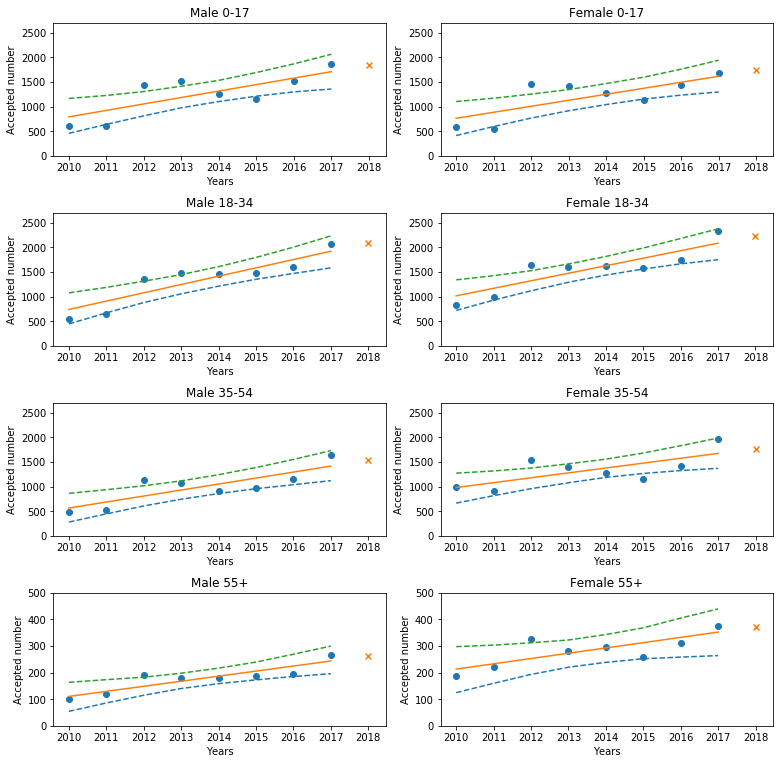

In [72]:
plot_results(fit_hier_sgm_alpha,all_mus2_5,all_mus97_5,all_people)

__Posterior predictive checking__

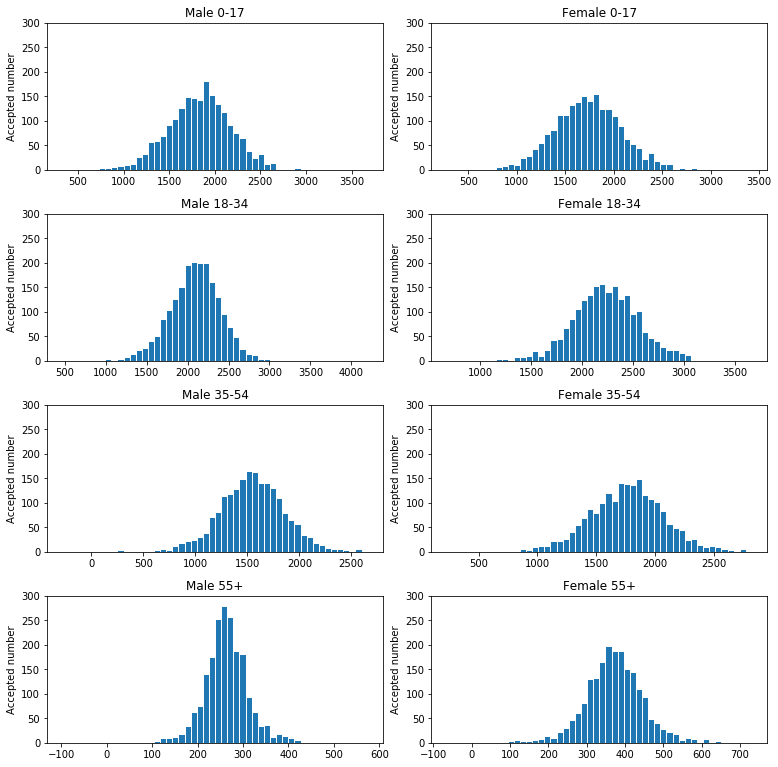

In [73]:
new_predictions = fit_hier_sgm_alpha.extract()['y_pred_18']
new_predictions = new_predictions.T

posterior_predictions(new_predictions)

# Hierarchical model for $\alpha$ and $\sigma$ and normal prior on $\mu_{0\alpha}$

In [74]:
population_model_hierarchical ="""
data{
    int<lower=0> N;         // number of data points
    int<lower=0> G;         // number of groups
    vector[N] years;        // years 2010...2017
    vector<lower=0>[N] y;   // the actual number of accepted citizens
    int grps_ind[N];        // group indicator vector (1,2,...,8,1,2...,8...)
    real xpred;             // year 2018
    
    real prior_mu;
    real<lower=0>prior_sigma;
}
parameters{
    vector[G] alpha;           // regression paramters for our 
    vector[G] beta;            // data points means (separate for each age category)
    vector<lower=0>[G] sigma;  // common sigma for each group
    real mu0_alpha;
    real<lower=0>sigma0_alpha;

    real p1;
    real p2;
}
transformed parameters{
    vector[N] mu;
    for (i in 1:N)                 
        mu[i] =  alpha[grps_ind[i]]*years[i] + beta[grps_ind[i]]; 
                                            // transformed mu as a 
                                            // linear function of years
}
model{
    mu0_alpha ~ normal(prior_mu,prior_sigma);
    sigma ~ cauchy(p1, p2);
                        // hierarchy on sigma
    alpha ~ normal(mu0_alpha,sigma0_alpha);
                        // hierarchy on alpha
    for (i in 1:N)
        y[i] ~ normal(mu[i],sigma[grps_ind[i]]);
                    // normal distribution around 
                    // each point;
}
generated quantities {
    vector[G] y_pred_18;
    vector[N] log_lik;
    real x_pred;
    for (i in 1:G)
        y_pred_18[i] = normal_rng(alpha[grps_ind[i]]*xpred +
                        beta[grps_ind[i]],sigma[grps_ind[i]]);
    
    for (i in 1:N)
        log_lik[i] = normal_lpdf(y[i] | mu[i], sigma[grps_ind[i]]);

}

"""

In [75]:
hierarchical_both_parameters = \
    pystan.StanModel(model_code=population_model_hierarchical)

years = np.array(list(range(2010,2018,1))).reshape((8,1))
years = np.tile(years,8).flatten()

hierarchical_data ={
    'N': all_people.size,
    'G':8,
    'years':years,
    'y': all_people.flatten(),
    'grps_ind': list(range(1,9,1))*8,
    'xpred': 2018,
    'prior_sigma': 400,
    'prior_mu': 21.46875
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f6cca5b656ce3cc9617de1d46cf1b8fe NOW.
/home/alex/anaconda3/envs/bda_env/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpf1804j54/stanfit4anon_model_f6cca5b656ce3cc9617de1d46cf1b8fe_7545276434119575870.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [76]:
fit_hier_Nprior = hierarchical_both_parameters.sampling(data=hierarchical_data,
                iter=1000,chains=4,control={"adapt_delta":0.95,"max_treedepth":18})


__Convergence analysis__

In [77]:
summary = fit_seaprate_no_prior.summary(pars=['alpha','beta','sigma'])

df = pd.DataFrame(
    summary['summary'],
    index = summary['summary_rownames'],
    columns = summary['summary_colnames'])
df.loc['beta[1]':'beta[9]','n_eff':'Rhat'].T

,beta[1],beta[2],beta[3],beta[4],beta[5],beta[6],beta[7],beta[8]
n_eff,734.275339,681.194171,1168.296961,714.672116,757.918865,751.080396,871.690488,777.948031
Rhat,1.003142,1.001217,1.001884,0.999747,1.002840,1.001747,0.999858,1.002494


In [78]:
df.loc['alpha[1]':'alpha[9]','n_eff':'Rhat'].T

,alpha[1],alpha[2],alpha[3],alpha[4],alpha[5],alpha[6],alpha[7],alpha[8]
n_eff,734.188842,681.156212,1168.019819,714.159016,757.936822,751.187152,871.753992,777.940796
Rhat,1.003142,1.001220,1.001884,0.999746,1.002839,1.001750,0.999860,1.002497


-426.64428780549184


(array([ 1.,  1.,  2.,  9., 13., 12., 14.,  7.,  2.,  3.]),
 array([-0.22337968, -0.11627736, -0.00917503,  0.0979273 ,  0.20502963,
         0.31213196,  0.41923428,  0.52633661,  0.63343894,  0.74054127,
         0.8476436 ]),
 <a list of 10 Patch objects>)

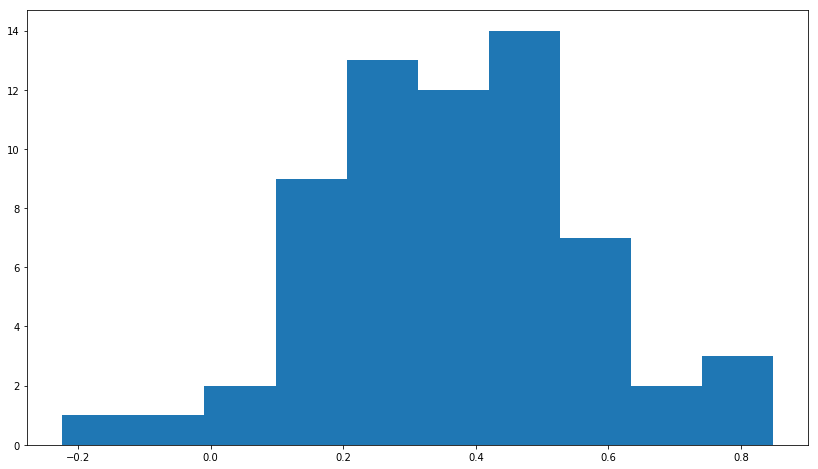

In [79]:
results = psis.psisloo(fit_hier_Nprior.extract()['log_lik'])
log_lik = fit_hier_Nprior.extract()['log_lik']
means = np.mean(np.exp(log_lik),axis=0)
sums = np.sum(np.log(means))
p_eff = sums  - results[0]
print(results[0])
plt.hist(psis.psisloo(fit_hier_Nprior.extract()['log_lik'])[2])


__P_eff value__

In [80]:
print(p_eff)

17.0634389663565


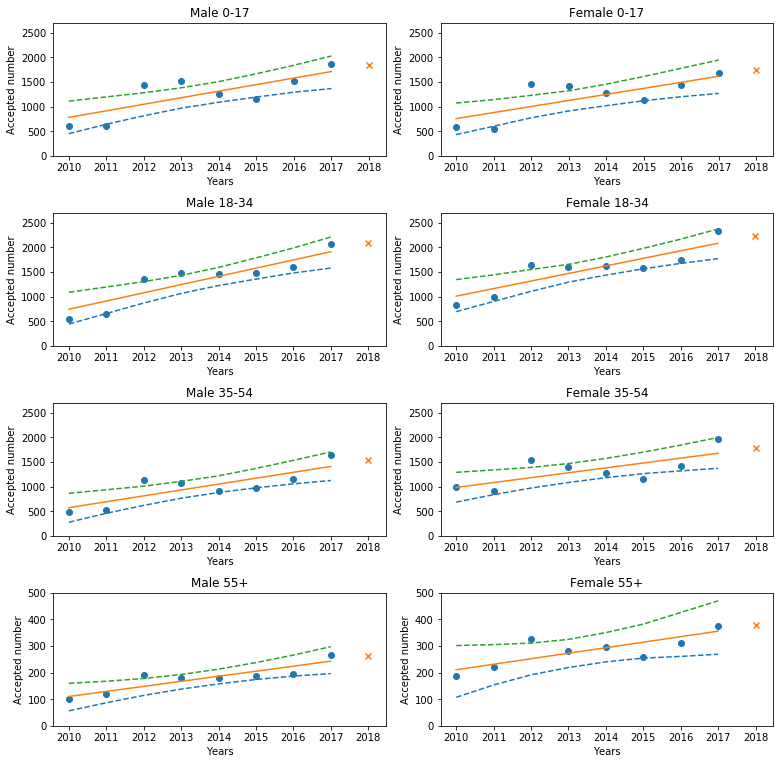

In [81]:
summary = fit_hier_Nprior.summary(pars=['mu'])


df = pd.DataFrame(
    summary['summary'],
    index = summary['summary_rownames'],
    columns = summary['summary_colnames'])

all_mus2_5 = []
all_mus97_5 = []
for i in range(1,65):
    current_mu = df.loc['mu[' + str(i)+ "]"]
    all_mus2_5.append(current_mu[3])
    all_mus97_5.append(current_mu[7])
    

all_mus2_5 = np.array(all_mus2_5)
all_mus97_5 = np.array(all_mus97_5)
all_mus2_5 = np.reshape(all_mus2_5,(8,8))
all_mus97_5 = np.reshape(all_mus97_5,(8,8))

plot_results(fit_hier_Nprior,all_mus2_5,all_mus97_5,all_people)

__Posterior predictive checking__

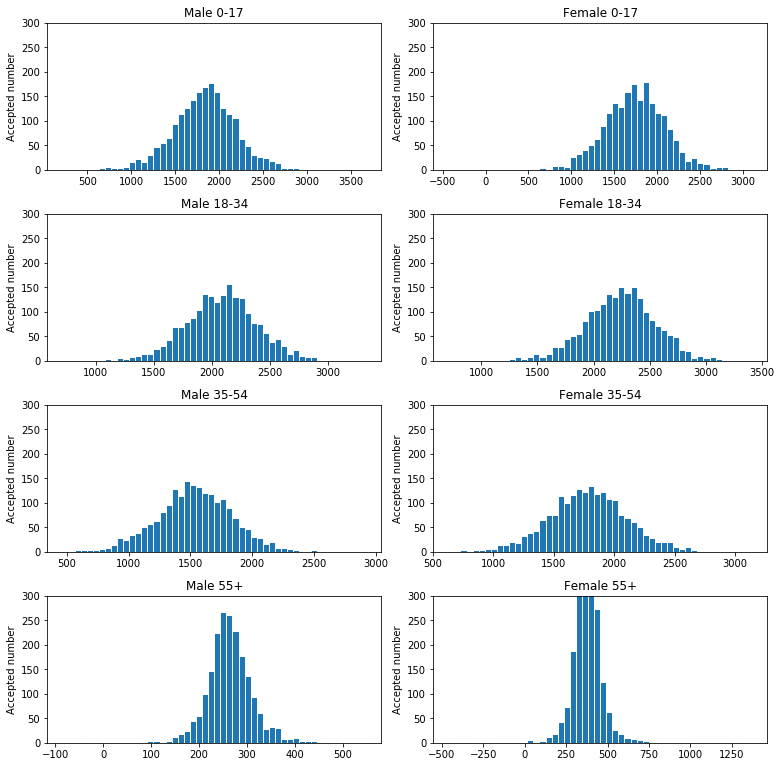

In [82]:
new_predictions = fit_hier_Nprior.extract()['y_pred_18']
new_predictions = new_predictions.T

posterior_predictions(new_predictions)

# Hierarchical model for $\alpha$ and $\sigma$ and normal, more informative prior on $\mu_{0\alpha}$

In [83]:
population_model_hierarchical ="""
data{
    int<lower=0> N;         // number of data points
    int<lower=0> G;         // number of groups
    vector[N] years;        // years 2010...2017
    vector<lower=0>[N] y;   // the actual number of accepted citizens
    int grps_ind[N];        // group indicator vector (1,2,...,8,1,2...,8...)
    real xpred;             // year 2018
    
    real prior_mu;
    real<lower=0>prior_sigma;
}
parameters{
    vector[G] alpha;           // regression paramters for our 
    vector[G] beta;            // data points means (separate for each age category)
    vector<lower=0>[G] sigma;  // common sigma for each group
    real mu0_alpha;
    real<lower=0>sigma0_alpha;

    real p1;
    real p2;
}
transformed parameters{
    vector[N] mu;
    for (i in 1:N)                 
        mu[i] =  alpha[grps_ind[i]]*years[i] + beta[grps_ind[i]]; 
                                            // transformed mu as a 
                                            // linear function of years
}
model{
    mu0_alpha ~ normal(prior_mu,prior_sigma);
    sigma ~ cauchy(p1, p2);
                        // hierarchy on sigma
    alpha ~ normal(mu0_alpha,sigma0_alpha);
                        // hierarchy on alpha
    for (i in 1:N)
        y[i] ~ normal(mu[i],sigma[grps_ind[i]]);
                    // normal distribution around 
                    // each point;
}
generated quantities {
    vector[G] y_pred_18;
    vector[N] log_lik;
    real x_pred;
    for (i in 1:G)
        y_pred_18[i] = normal_rng(alpha[grps_ind[i]]*xpred +
                        beta[grps_ind[i]],sigma[grps_ind[i]]);
    
    for (i in 1:N)
        log_lik[i] = normal_lpdf(y[i] | mu[i], sigma[grps_ind[i]]);

}

"""

In [84]:
hierarchical_both_parameters = \
    pystan.StanModel(model_code=population_model_hierarchical)

years = np.array(list(range(2010,2018,1))).reshape((8,1))
years = np.tile(years,8).flatten()

hierarchical_data ={
    'N': all_people.size,
    'G':8,
    'years':years,
    'y': all_people.flatten(),
    'grps_ind': list(range(1,9,1))*8,
    'xpred': 2018,
    'prior_sigma': 168.07,
    'prior_mu': 21.46875
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f6cca5b656ce3cc9617de1d46cf1b8fe NOW.
/home/alex/anaconda3/envs/bda_env/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp19cjhtpx/stanfit4anon_model_f6cca5b656ce3cc9617de1d46cf1b8fe_7466458076390614248.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [85]:
fit_hier_Nprior = hierarchical_both_parameters.sampling(data=hierarchical_data,
                iter=1000,chains=4,control={"adapt_delta":0.95,"max_treedepth":18})

-427.3984888207392


(array([ 3.,  3.,  6., 10.,  8., 13.,  5.,  5.,  3.,  8.]),
 array([-0.12458883, -0.03483978,  0.05490927,  0.14465832,  0.23440737,
         0.32415642,  0.41390547,  0.50365452,  0.59340357,  0.68315262,
         0.77290168]),
 <a list of 10 Patch objects>)

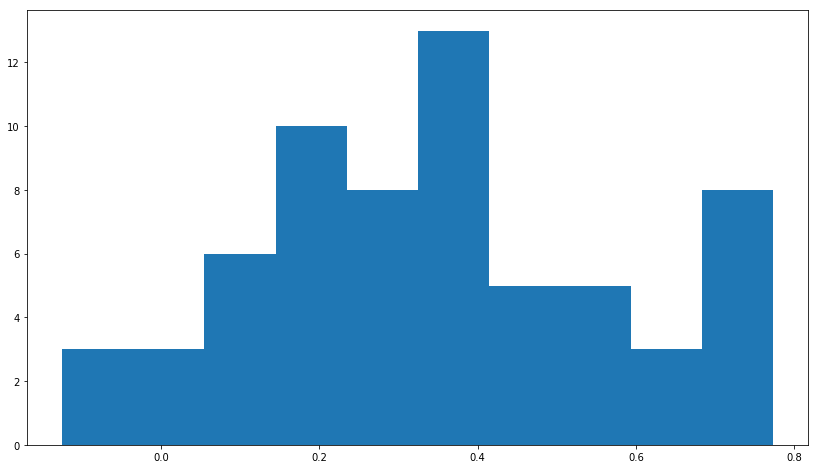

In [86]:
results = psis.psisloo(fit_hier_Nprior.extract()['log_lik'])
log_lik = fit_hier_Nprior.extract()['log_lik']
means = np.mean(np.exp(log_lik),axis=0)
sums = np.sum(np.log(means))
p_eff = sums  - results[0]
print(results[0])
plt.hist(psis.psisloo(fit_hier_Nprior.extract()['log_lik'])[2])

__P_eff value__

In [87]:
print(p_eff)

17.462723095558886


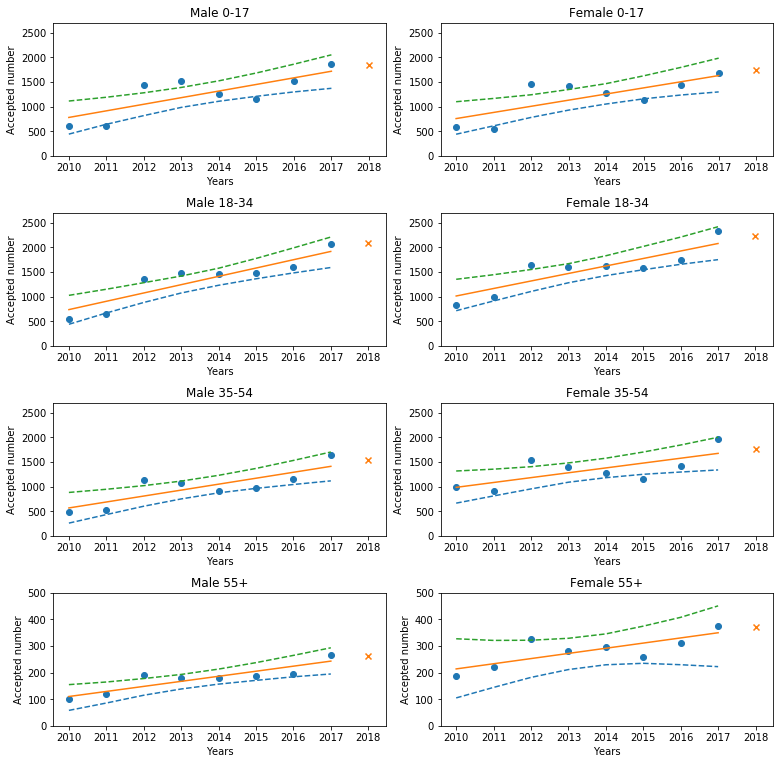

In [88]:
summary = fit_hier_Nprior.summary(pars=['mu'])


df = pd.DataFrame(
    summary['summary'],
    index = summary['summary_rownames'],
    columns = summary['summary_colnames'])

all_mus2_5 = []
all_mus97_5 = []
for i in range(1,65):
    current_mu = df.loc['mu[' + str(i)+ "]"]
    all_mus2_5.append(current_mu[3])
    all_mus97_5.append(current_mu[7])
    

all_mus2_5 = np.array(all_mus2_5)
all_mus97_5 = np.array(all_mus97_5)
all_mus2_5 = np.reshape(all_mus2_5,(8,8))
all_mus97_5 = np.reshape(all_mus97_5,(8,8))

plot_results(fit_hier_Nprior,all_mus2_5,all_mus97_5,all_people)

__Posterior predictive checking__

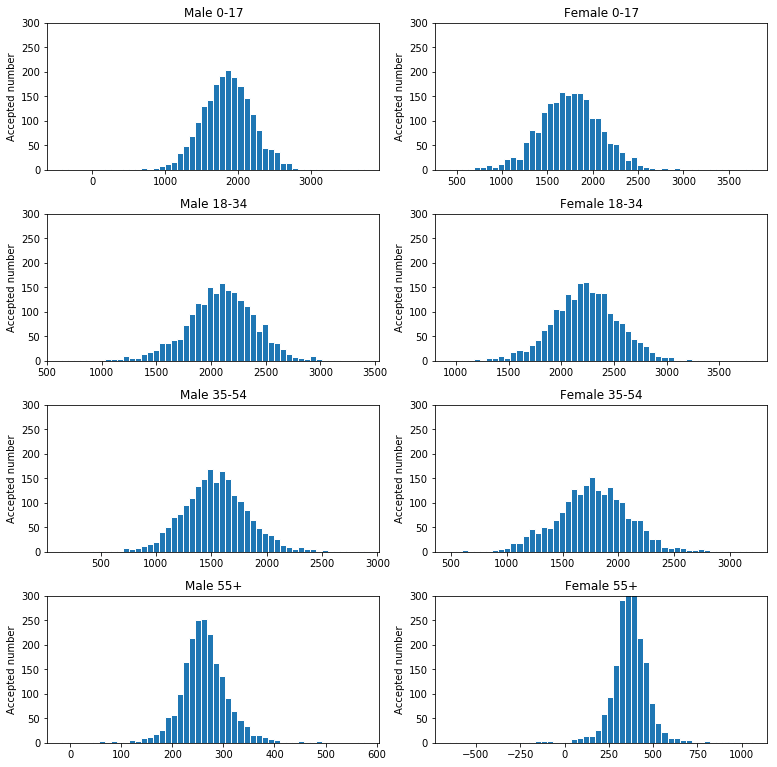

In [89]:
new_predictions = fit_hier_Nprior.extract()['y_pred_18']
new_predictions = new_predictions.T

posterior_predictions(new_predictions)

# Hierarchical model for $\alpha$ and $\sigma$ and normal, more informative prior on $\mu_{0\alpha}$, with an intuition that the slope becomes steeper

In [90]:
population_model_hierarchical ="""
data{
    int<lower=0> N;         // number of data points
    int<lower=0> G;         // number of groups
    vector[N] years;        // years 2010...2017
    vector<lower=0>[N] y;   // the actual number of accepted citizens
    int grps_ind[N];        // group indicator vector (1,2,...,8,1,2...,8...)
    real xpred;             // year 2018
    
    real prior_mu;
    real<lower=0>prior_sigma;
}
parameters{
    vector[G] alpha;           // regression paramters for our 
    vector[G] beta;            // data points means (separate for each age category)
    vector<lower=0>[G] sigma;  // common sigma for each group
    real mu0_alpha;
    real<lower=0>sigma0_alpha;

    real p1;
    real p2;
}
transformed parameters{
    vector[N] mu;
    for (i in 1:N)                 
        mu[i] =  alpha[grps_ind[i]]*years[i] + beta[grps_ind[i]]; 
                                            // transformed mu as a 
                                            // linear function of years
}
model{
    mu0_alpha ~ normal(prior_mu,prior_sigma);
    sigma ~ cauchy(p1, p2);
                        // hierarchy on sigma
    alpha ~ normal(mu0_alpha,sigma0_alpha);
                        // hierarchy on alpha
    for (i in 1:N)
        y[i] ~ normal(mu[i],sigma[grps_ind[i]]);
                    // normal distribution around 
                    // each point;
}
generated quantities {
    vector[G] y_pred_18;
    vector[N] log_lik;
    real x_pred;
    for (i in 1:G)
        y_pred_18[i] = normal_rng(alpha[grps_ind[i]]*xpred +
                        beta[grps_ind[i]],sigma[grps_ind[i]]);
    
    for (i in 1:N)
        log_lik[i] = normal_lpdf(y[i] | mu[i], sigma[grps_ind[i]]);

}

"""

In [91]:
hierarchical_both_parameters = \
    pystan.StanModel(model_code=population_model_hierarchical)

years = np.array(list(range(2010,2018,1))).reshape((8,1))
years = np.tile(years,8).flatten()

hierarchical_data ={
    'N': all_people.size,
    'G':8,
    'years':years,
    'y': all_people.flatten(),
    'grps_ind': list(range(1,9,1))*8,
    'xpred': 2018,
    'prior_sigma': 300,
    'prior_mu': 200
}



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f6cca5b656ce3cc9617de1d46cf1b8fe NOW.
/home/alex/anaconda3/envs/bda_env/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmpoxy14vej/stanfit4anon_model_f6cca5b656ce3cc9617de1d46cf1b8fe_7264422679865651060.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [92]:
fit_hier_Nprior = hierarchical_both_parameters.sampling(data=hierarchical_data,
                iter=1000,chains=4,control={"adapt_delta":0.95,"max_treedepth":18})


__Convergence analysis__

In [93]:
summary = fit_hier_Nprior.summary(pars=['alpha','beta','sigma'])

df = pd.DataFrame(
    summary['summary'],
    index = summary['summary_rownames'],
    columns = summary['summary_colnames'])



df.loc['beta[1]':'beta[9]','n_eff':'Rhat'].T

,beta[1],beta[2],beta[3],beta[4],beta[5],beta[6],beta[7],beta[8]
n_eff,1236.711789,844.231043,1092.147070,878.071118,1338.419931,1238.570799,1267.799574,640.227906
Rhat,1.000098,1.001636,1.000763,1.002927,1.004044,1.001770,0.999701,1.005172


In [94]:
df.loc['alpha[1]':'alpha[9]','n_eff':'Rhat'].T

,alpha[1],alpha[2],alpha[3],alpha[4],alpha[5],alpha[6],alpha[7],alpha[8]
n_eff,1236.722551,844.156568,1092.365732,878.088970,1338.260366,1238.628610,1268.105920,639.814341
Rhat,1.000098,1.001635,1.000763,1.002928,1.004042,1.001772,0.999702,1.005178


-427.1226659059268


(array([ 2.,  1.,  5.,  9., 13.,  9.,  9., 11.,  3.,  2.]),
 array([-0.18837416, -0.08109246,  0.02618923,  0.13347092,  0.24075261,
         0.34803431,  0.455316  ,  0.56259769,  0.66987939,  0.77716108,
         0.88444277]),
 <a list of 10 Patch objects>)

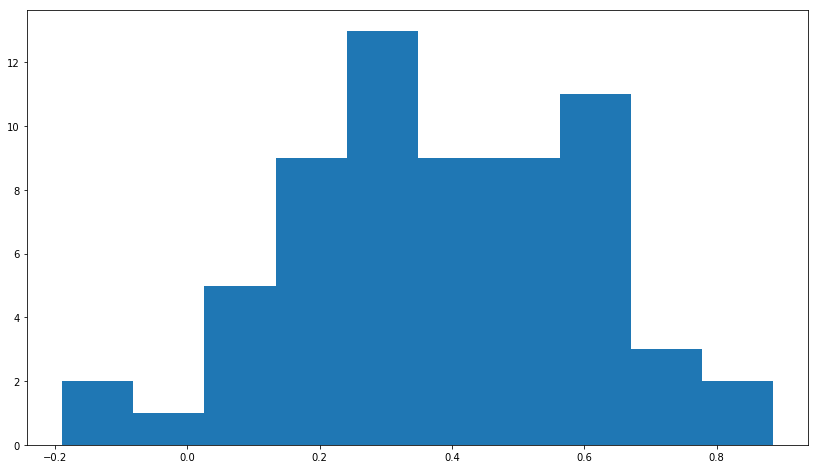

In [95]:
results = psis.psisloo(fit_hier_Nprior.extract()['log_lik'])
log_lik = fit_hier_Nprior.extract()['log_lik']
means = np.mean(np.exp(log_lik),axis=0)
sums = np.sum(np.log(means))
p_eff = sums  - results[0]
print(results[0])
plt.hist(psis.psisloo(fit_hier_Nprior.extract()['log_lik'])[2])


__P_eff value__

In [96]:
print(p_eff)

17.31391390177913


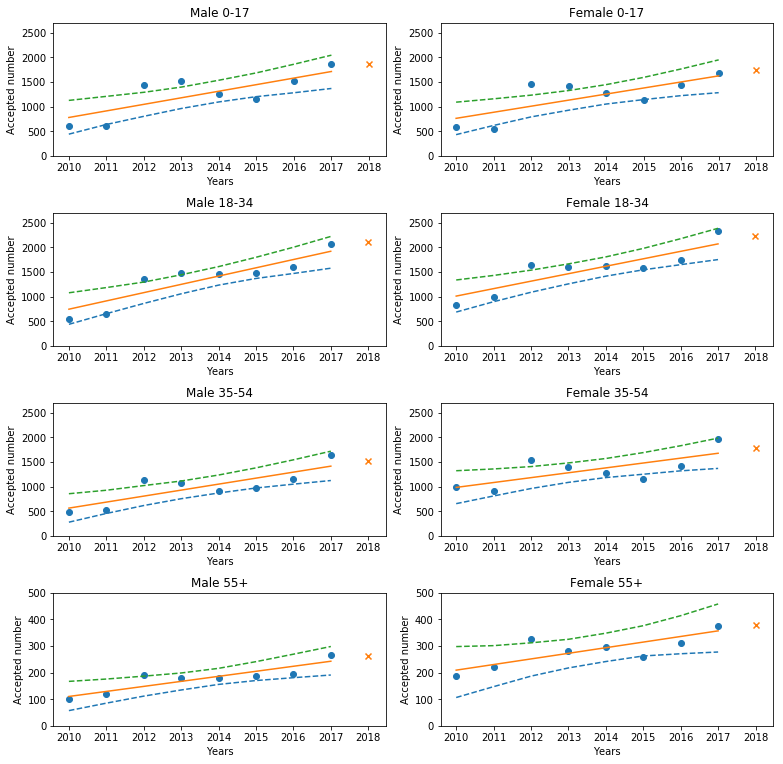

In [97]:
summary = fit_hier_Nprior.summary(pars=['mu'])


df = pd.DataFrame(
    summary['summary'],
    index = summary['summary_rownames'],
    columns = summary['summary_colnames'])

all_mus2_5 = []
all_mus97_5 = []
for i in range(1,65):
    current_mu = df.loc['mu[' + str(i)+ "]"]
    all_mus2_5.append(current_mu[3])
    all_mus97_5.append(current_mu[7])
    

all_mus2_5 = np.array(all_mus2_5)
all_mus97_5 = np.array(all_mus97_5)
all_mus2_5 = np.reshape(all_mus2_5,(8,8))
all_mus97_5 = np.reshape(all_mus97_5,(8,8))

plot_results(fit_hier_Nprior,all_mus2_5,all_mus97_5,all_people)

__Posterior predictive checking__

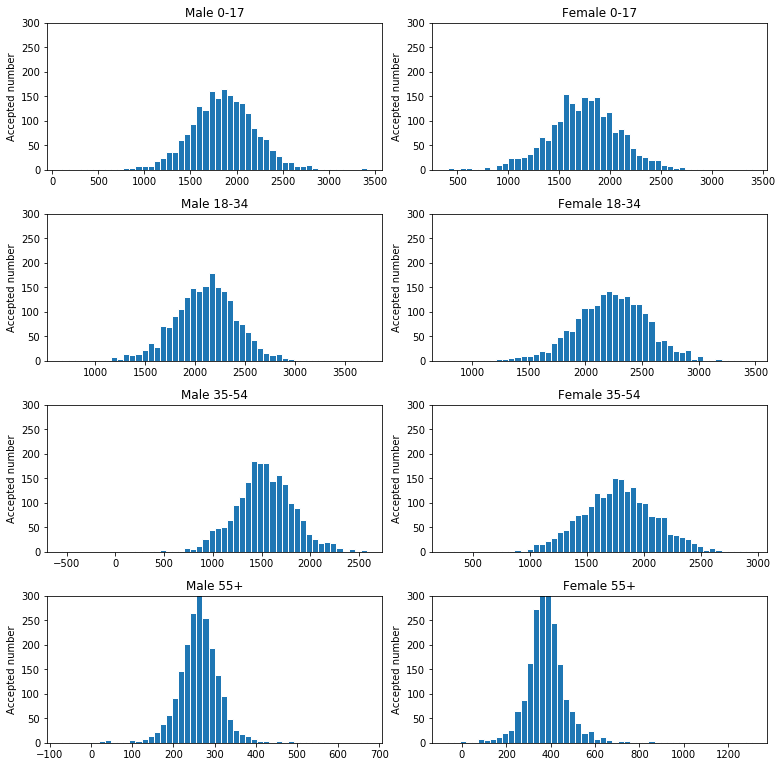

In [98]:
new_predictions = fit_hier_Nprior.extract()['y_pred_18']
new_predictions = new_predictions.T

posterior_predictions(new_predictions)

# Summary

| Model                              | Prior         | psis-loo value | p_eff | k_max  |
|------------------------------------|---------------|----------------|-------|--------|
| Separate                           | Flat Prior    |-430.46         |17.56  |0.68    |
| Separate                           | N(21.46,168)  |-429.18         |16.93  |0.83    |
| Hierarchical $\alpha$              | Flat Prior    |-429.65         |16.59  |0.736   |
| Hierarchical $\beta$               | Flat Prior    |-430.46         |16.59  |0.73    |
| Hierarchical $\alpha$ and $\sigma$ | Flat Prior    |-427.51         |17.49  |0.68    |
| Pooled                             | Flat Prior    |-35078.89       |4065.03|12.12   |